In [1]:
import numpy as np
import pandas as pd
import gudhi as gd
import math
import statsmodels.api as sm 
import gudhi.representations
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.representations.vector_methods import Landscape
from gudhi.representations.vector_methods import Silhouette
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from numpy import linalg as LA
from sklearn import linear_model
import skfda.misc.metrics as mt
import skfda
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr,kurtosis,norm
import seaborn as sns
import random
import gtda.mapper as gmp
import persim.persistent_entropy as pe
import statsmodels.tsa.api as smt
from persim import plot_diagrams
import seaborn as sns
from scipy.stats import kde



class TDATimeSeries():
    
    
    def __init__(self,d=2,tau=1):
        self.LS = gd.representations.Landscape(resolution=1000, num_landscapes = 5)
        self.TD = TimeDelayEmbedding(dim = d,delay = tau)
    
    def plotEmbeddedTimeSeries(self,timeSeries):
        embedded = self.TD.__call__(timeSeries)
        x = [p[0] for p in embedded]
        y = [p[1] for p in embedded] 
        fig = plt.figure(figsize=(5,5))
        fig.suptitle('Embedded Time Series', fontsize=15)
        plt.scatter(x,y,color='b',s=0.2)
        plt.grid(True)
    
    def plotEmbeddedTimeSeriesDensity(self,timeSeries):
        embedded = self.TD.__call__(timeSeries)
        x = np.array([p[0] for p in embedded])
        y = np.array([p[1] for p in embedded]) 
        
        nbins=300
        k = kde.gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
        plt.show()

        plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
        plt.show()
    
    def persistenceDiagram(self,timeSeries,maxdim=2):
        embedded = self.TD.__call__(timeSeries)
        return ripser(embedded,maxdim)['dgms']
    
    def plotPersistenceDiagram(self,timeSeries,maxdim=2):
        plot_diagrams(self.persistenceDiagram(timeSeries,maxdim),show=True)
        
    def plotPersistenceDiagramDensity(self,timeSeries,maxdim=2):
        diagram = self.persistenceDiagram(timeSeries)
        
        x = np.array([x[0] for x in diagram[1]])
        y = np.array([x[1] for x in diagram[1]])
        
        nbins=300
        k = kde.gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
        plt.show()
        
        plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
        plt.show()
    
    def persistenceLandscapes(self,timeSeries,p=1):
        embedded = self.TD.__call__(timeSeries)
        try:
            diagram = self.persistenceDiagram(timeSeries)
            landscape = self.LS.fit_transform([diagram[1]])[0]
        except:
            landscape = None
        return landscape
    
    def persistenceLandscapesLpNorm(self,timeSeries,p=1,landscapesInConsideration = 5, samplePointsNumber = 1000):
        
        landscape = self.persistenceLandscapes(timeSeries,p)
        if landscape is None:
            return 0
        sample_range = self.LS.sample_range
        return sum([mt.lp_norm(skfda.FDataGrid([landscape[samplePointsNumber*i:samplePointsNumber*(i+1)]],np.linspace(sample_range[0],sample_range[1],samplePointsNumber)),p) for i in range(0,landscapesInConsideration)])
        
    
    def powerWeightedSilhouette(self,timeSeries,p=1):
        embedded = self.TD.__call__(timeSeries)
        acX = gd.AlphaComplex(points=embedded).create_simplex_tree()
        dgmX = acX.persistence()
        SH = gd.representations.Silhouette(resolution=1000, weight=lambda x: 1)
        return SH.fit_transform([acX.persistence_intervals_in_dimension(1)])[0]
        
   
    def powerWeightedSilhouetteLpNorm(self,timeSeries,Lp=1,p=1):
        silhouette = silhouette(timeSeries,p)
        return mt.lp_norm(skfda.FDataGrid(silhouette[0],np.linspace(silhouette.sample_range[0],silhouette.sample_range[1],1000)),p)
        
    def persistenceEntropy(self,timeSeries,d):
        embedded = self.TD.__call__(timeSeries)
        diagram = self.persistenceDiagram(timeSeries,maxdim=1)[d]
        return pe.persistent_entropy(diagram,normalize=True)

   
    def ES(self, timeSeries,d):

        diagram = self.persistenceDiagram(timeSeries)

        if d == 0:
            diagram = diagram[0][:-1]
        else:
            diagram = diagram[1]

        l = [d[1] - d[0] for d in diagram]
        L = sum(l)
        xo = sorted(diagram, key = lambda x: x[0])[0][0]
        xf = sorted(diagram, key = lambda x: x[1])[-1][1]
        instants = np.linspace(xo,xf,1000)
        diagrams  = [[d for d in diagram if d[0] <= t and t <= d[1]] for t in instants]
        dls = [[i[1] - i[0] for i in di] for di in diagrams]
        ES = np.array([sum([-(l/L)*math.log(l/L) for l in ls]) for ls in dls])
        return instants, ES

    def NES(self,timeSeries,d):
        instants, ES = self.ES(timeSeries,d)
        NES = ES/(mt.lp_norm(skfda.FDataGrid(ES,instants),1))
        return instants, NES
    


In [56]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import semicircular



def ar_1(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    c = mu * (1 - corr)
    sigma_e = np.sqrt(sigma**2*(1 - corr ** 2))

    signal = [c + np.random.normal(0, sigma_e)]
    
    for _ in range(1, n_samples):
        signal.append(c + corr* signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)
    

def arch_1(n_samples,a0,a1):

    w = np.random.normal(size = n_samples)
    eps = np.zeros_like(w)
    sigsq = np.zeros_like(w)

    for i in range(1, n_samples):
        sigsq[i] = a0 + a1*(eps[i-1]**2)
        eps[i] = w[i] * np.sqrt(sigsq[i])
       
    return eps

def garch_1_1(n_samples,a0,a1,b1):
    
    w = np.random.normal(size = n_samples)
    eps = np.zeros_like(w)
    sigsq = np.zeros_like(w)

    for i in range(1, n_samples):
        sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
        eps[i] = w[i] * np.sqrt(sigsq[i])
       
    return eps

def laplaceTS(n_samples,mu=0, variance=1):
    return np.random.laplace(0, math.sqrt(variance/2), n_samples)

def logisticTS(n_samples,mu=0, variance=1):
    return np.random.logistic(mu, math.sqrt(variance*3)/math.pi, n_samples)

def normalTS(n_samples,mu=0, variance=1):
    return np.random.normal(mu, variance, n_samples)

def semicircularTS(n_samples,mu=0, variance=1):
    return semicircular.rvs(loc = mu,scale = 2*math.sqrt(variance),size=n_samples)

def uniformTS(n_samples,variance = 1): 
    return np.random.uniform(0,2*math.sqrt(variance*3),n_samples)

    
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [3]:
tda = TDATimeSeries()

# Plotting time series models and autocorrelation

### AR(1)

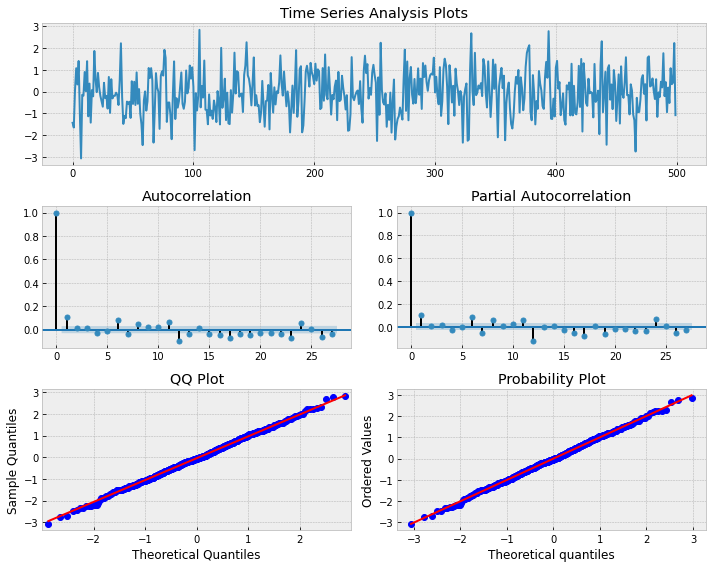

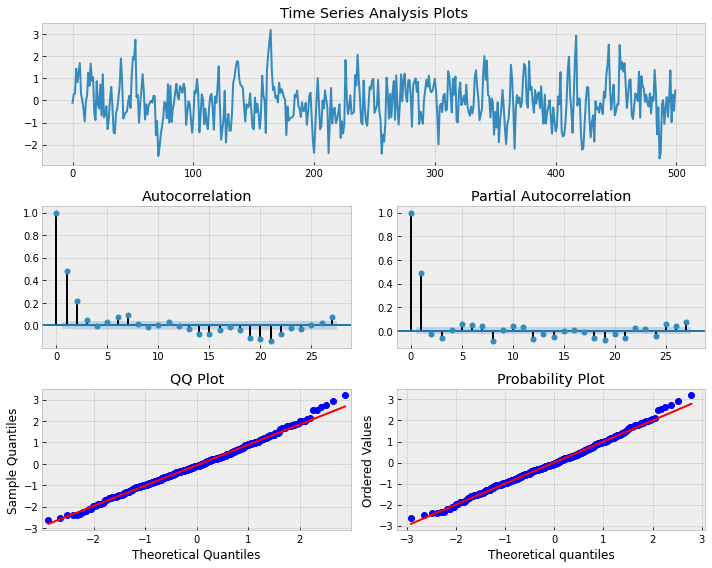

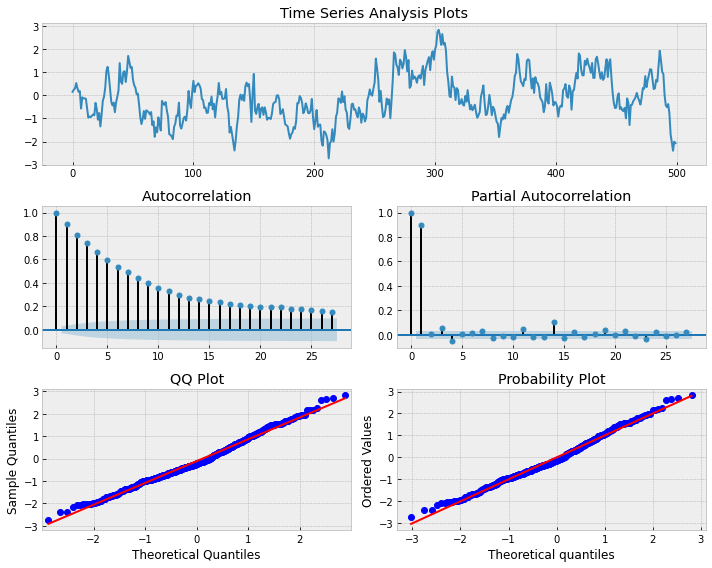

In [4]:
ar1 = ar_1(500,corr = 0.1)
tsplot(ar1)

ar1 = ar_1(500,corr = 0.5)
tsplot(ar1)

ar1 = ar_1(500,corr = 0.9)
tsplot(ar1)

### ARCH(1)

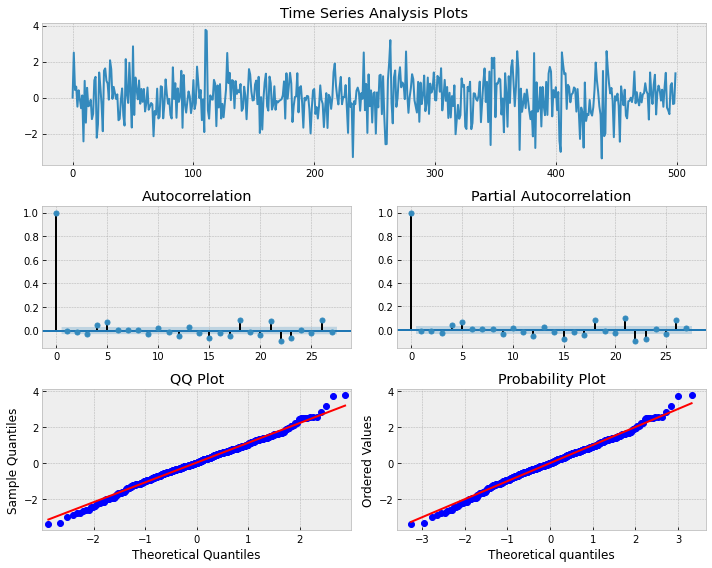

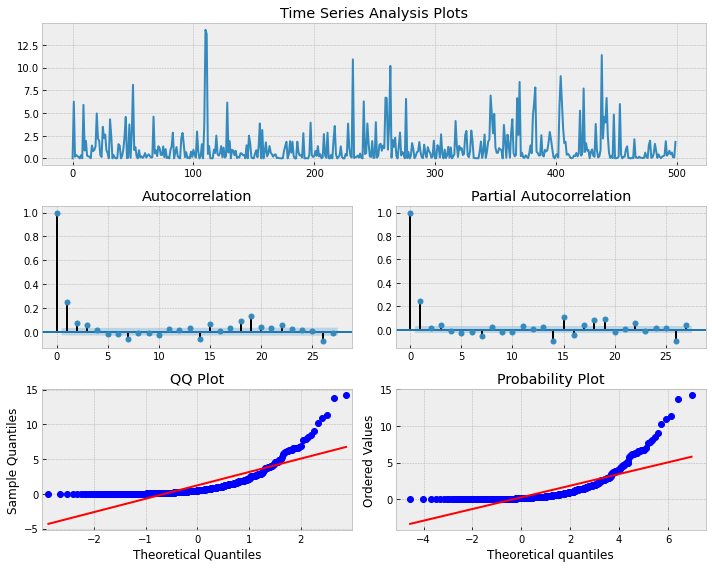

In [5]:
#ARCH(1) alpha_1 = theta, alpha_0 = 1 - theta (Plotting the series and its squared series)
theta = 0.1
arch1 = arch_1(500,1 - theta, theta)
tsplot(arch1)
tsplot(arch1**2)

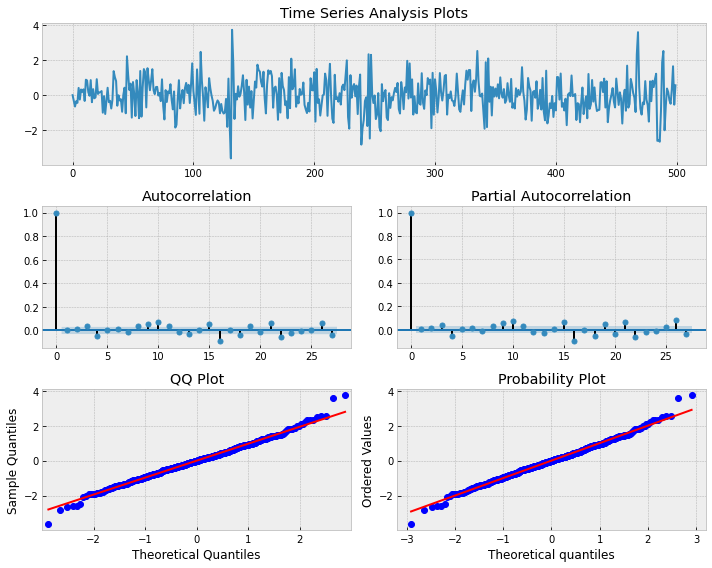

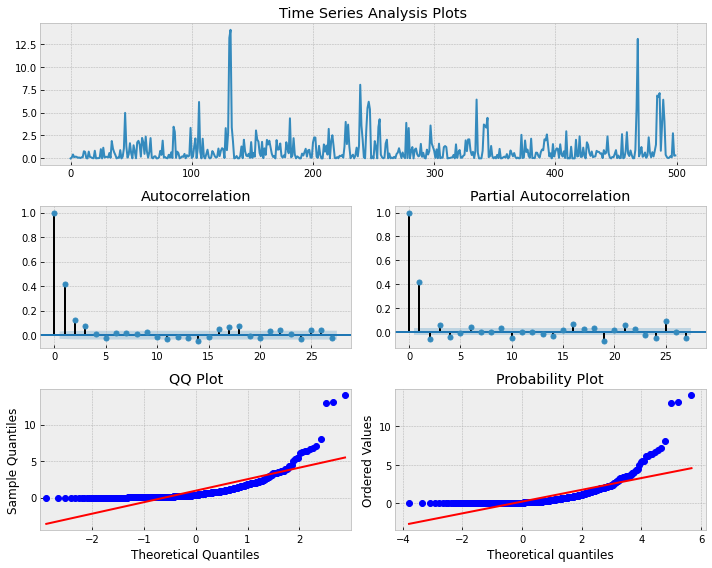

In [6]:
theta = 0.3
arch1 = arch_1(500,1 - theta, theta)
tsplot(arch1)
tsplot(arch1**2)

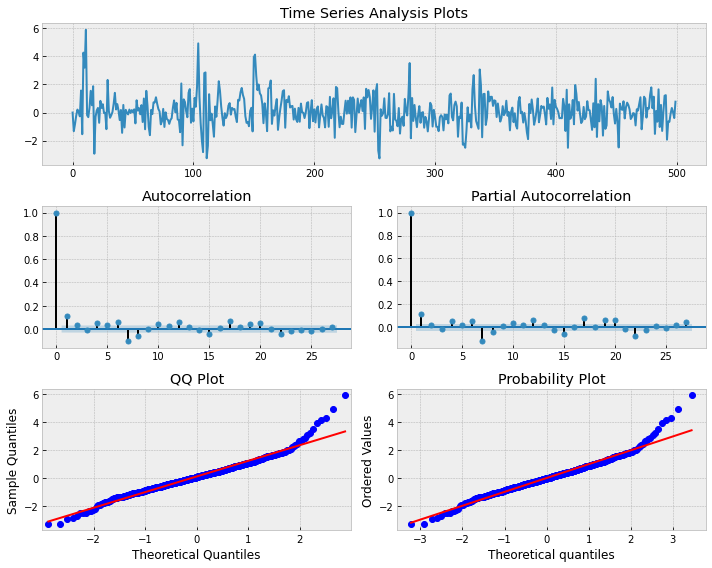

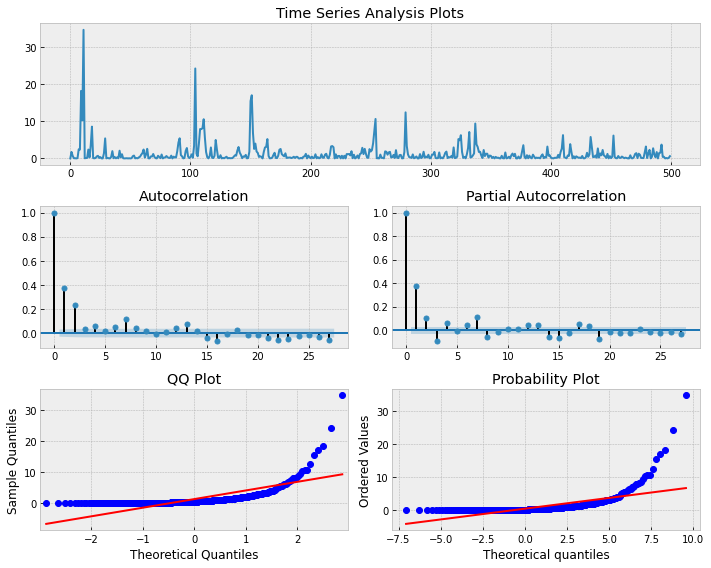

In [7]:
theta = 0.5
arch1 = arch_1(500,1 - theta, theta)
tsplot(arch1)
tsplot(arch1**2)

### GARCH(1,1)

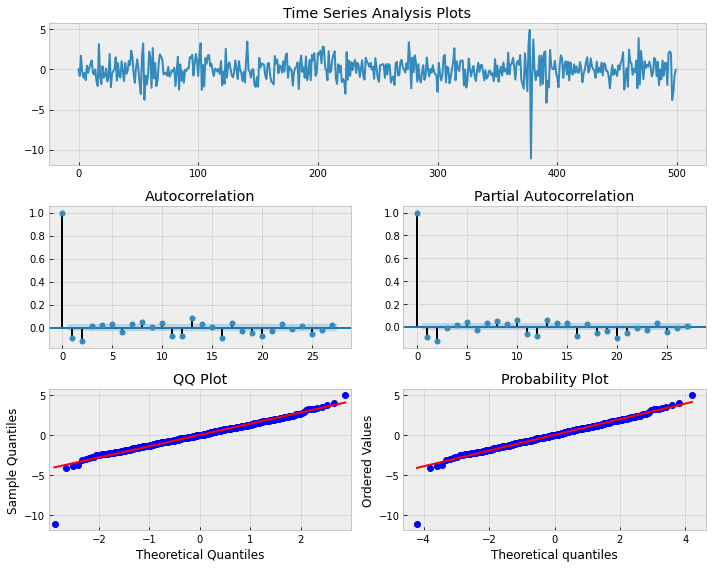

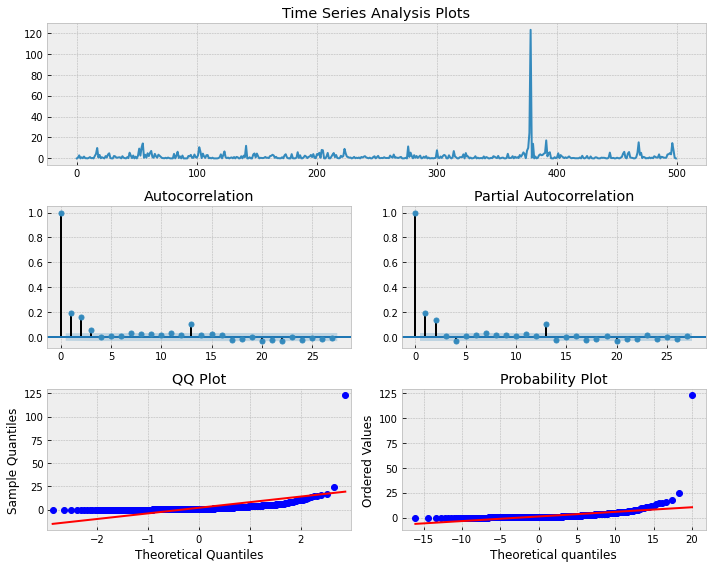

In [8]:
theta = 0.5
garch_1_1 = garch_1_1(500,1 - theta, theta, 0.3)
tsplot(garch_1_1)
tsplot(garch_1_1**2)

# Checking the autocorrelation effects on embedded time series.

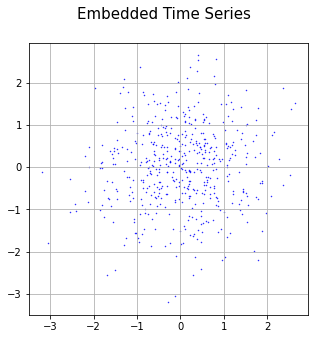

In [9]:
#Checking the effect of the autocorrelation on the embedded time series
ar1 = ar_1(500,corr = 0.1)
tda.plotEmbeddedTimeSeries(ar1)
#tda.plotEmbeddedTimeSeriesDensity(ar1)

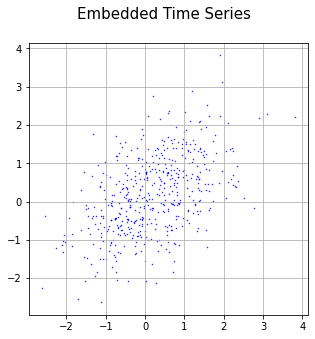

In [10]:
ar1 = ar_1(500,corr = 0.5)
tda.plotEmbeddedTimeSeries(ar1)
#tda.plotEmbeddedTimeSeriesDensity(ar1)

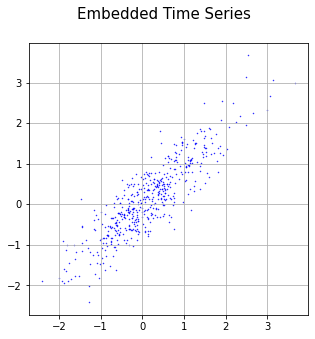

In [11]:
ar1 = ar_1(500,corr = 0.9)
tda.plotEmbeddedTimeSeries(ar1)
#tda.plotEmbeddedTimeSeriesDensity(ar1)

# TDA Functional Summaries and Methods

In [12]:
timeSeries = ar_1(75,corr = 0.5)

## Persistence Diagram

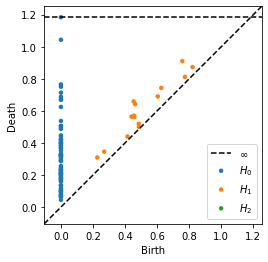

In [13]:
tda.plotPersistenceDiagram(timeSeries)

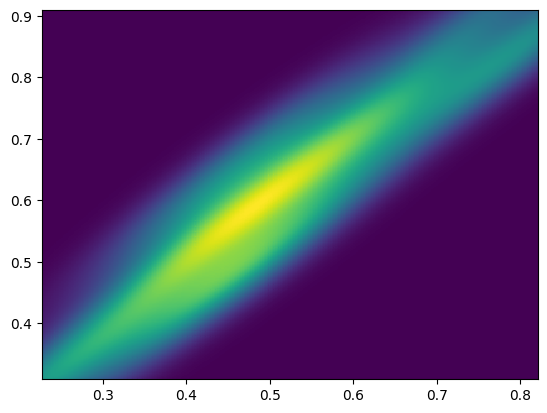

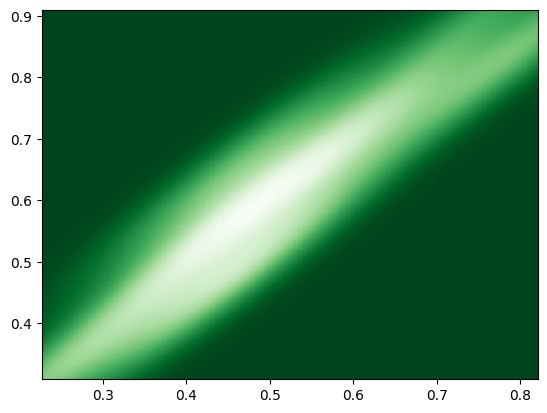

In [14]:
tda.plotPersistenceDiagramDensity(timeSeries)

## Persistence Landscape Norm

In [15]:
tda.persistenceLandscapesLpNorm(timeSeries)

0.06210776995990068

## Power Weighed Silhouette

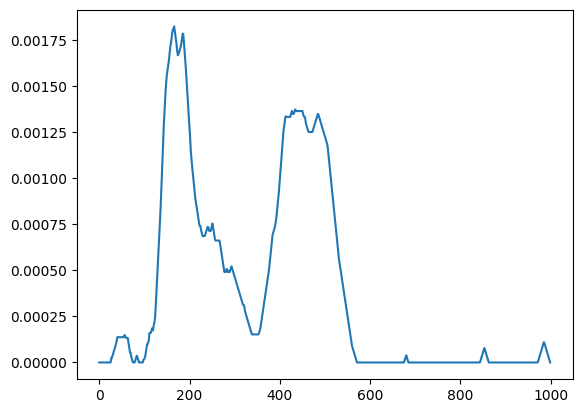

In [16]:
plt.plot(tda.powerWeightedSilhouette(timeSeries))

## Persistent Entropy, ES and NES

In [17]:
tda.persistenceEntropy(timeSeries,d=1)

array([0.93361051])

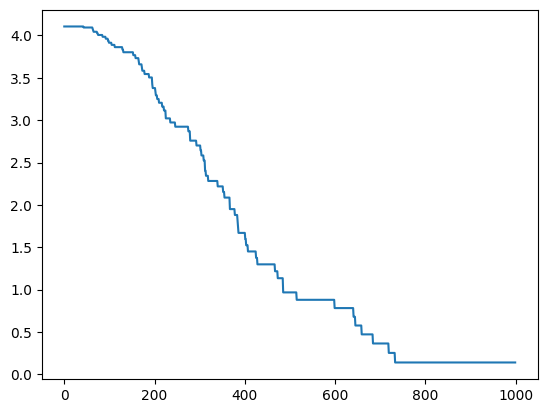

In [18]:
plt.plot(tda.ES(timeSeries,d=0)[1])

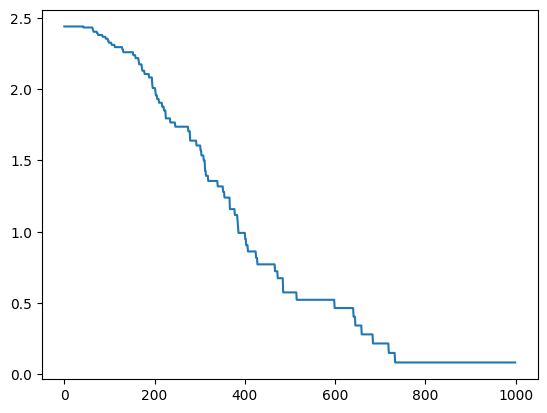

In [19]:
plt.plot(tda.NES(timeSeries,d=0)[1])

# Kurtosis Experiments

## Laplace

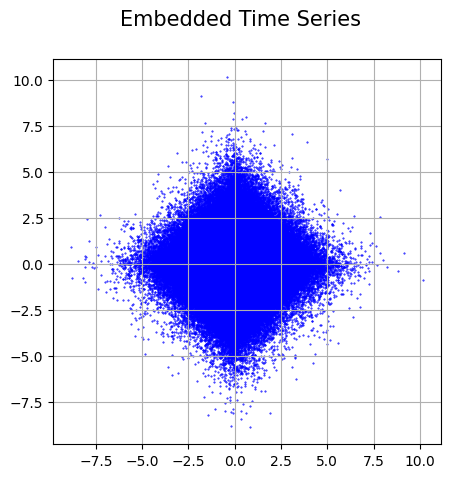

In [20]:
timeSeries = laplaceTS(1000000)
tda.plotEmbeddedTimeSeries(timeSeries)

## Logistic

In [ ]:
timeSeries = logisticTS(1000000)
tda.plotEmbeddedTimeSeries(timeSeries)

## Normal

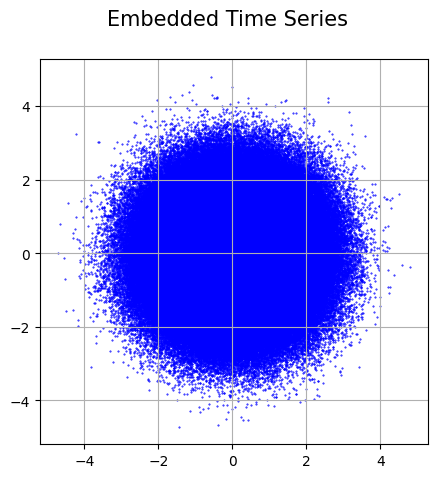

In [22]:
timeSeries = normalTS(1000000)
tda.plotEmbeddedTimeSeries(timeSeries)

## Semicircular

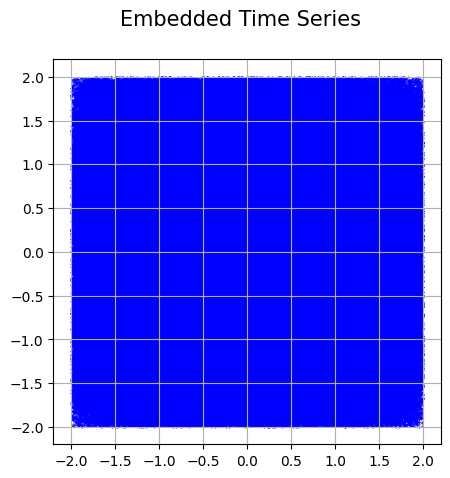

In [23]:
timeSeries = semicircularTS(1000000)
tda.plotEmbeddedTimeSeries(timeSeries)

## Uniform

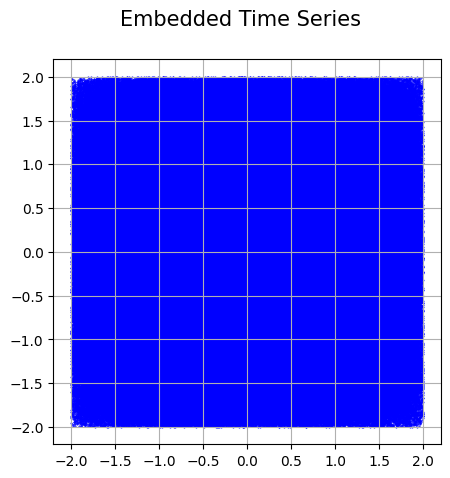

In [24]:
timeSeries = semicircularTS(1000000)
tda.plotEmbeddedTimeSeries(timeSeries)

# Autocorrelations and STD last experiment

In [68]:
#This is very hard to compute!!

def std_corr_persistence_landscape_lp_norm_surface(n_samples,n_sim,corr0=0.00001,corr1=0.99999,n_corrs=10,std0=1,std1=10,n_std=10):
    
    tda = TDATimeSeries()
    autocorrelations = np.linspace(corr0,corr1,n_corrs)
    stds = np.linspace(std0,std1,n_std)
    empiricalStds = []
    fixed_autocorr_LpNormSeries = []
   
    for corr in autocorrelations:
        fixed_std_LpNormSeries = []
        for std in stds:
            timeSeries = ar_1(n_samples,corr,sigma=std)
            fixed_std_LpNormSeries.append(np.mean(np.array([tda.persistenceLandscapesLpNorm(timeSeries) for _ in range(0,n_sim)])))    
        fixed_autocorr_LpNormSeries.append(fixed_std_LpNormSeries)
    fixed_autocorr_LpNormSeries = np.array(fixed_autocorr_LpNormSeries)
   
    x = [x for x in autocorrelations for i in range(len(stds))]
    y = [y for i in range(len(autocorrelations)) for y in stds]
    z = fixed_autocorr_LpNormSeries.ravel()
  
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x,y,z)
    